In [1]:
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import json
from sklearn import preprocessing
from random import *

from lib import audio_methods
from lib import formatter
from lib import base

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

# Data Exploration

## Reading in Data

Our dataframe has all the playlists in the first raw dataset. Our first goal is to create the user-item matrix, or in our case a playlist-track matrix. We assume each playlist an an unique user, and each track is an item. So we need to extract all the track IDs from each playlist first.

"Name", "Collaborative", "Modified_at", and "Num_edits" are deleted because we are not interested in metadata.

In [2]:
df = pd.DataFrame.from_dict(formatter.import_to_json("raw_data/p1.json"))
df = df.drop(['name','collaborative','modified_at','num_edits'],axis=1)

all_tracks = []
for i in range(0,1000):
    pl = df['tracks'][i]
    for j in range(0,len(pl)):
        all_tracks.append(pl[j]['track_uri'])
        
all_tracks = list(dict.fromkeys(all_tracks))
len(all_tracks)

34443

There are 34443 unique tracks in dataset 1.

# Constructing User-Item Matrix

Recommender systems use matrices to contain information about their items and/or users. A user-item matrix reveals which users have interactions with which items; a user-user matrix with users; and likewise with item-item matrices. We will be constructing a user-item matrix to start with.

A "1" means the track exists and "0" means it doesn't.

In [ ]:
##################################################
##         WARNING: *MAY* TAKE FOREVER          ##
##        Depending on system resources.        ##
##    Otherwise, run the next block instead.    ##           
##################################################

n = 1000 # number of playlists
user_item_matrix = pd.DataFrame(index=all_tracks,columns=range(0,n))

temp_pl = df['tracks'].tolist()
for i in range(0,n):
    temp_pl_i = temp_pl[i]
    temp_pl_i_len = len(temp_pl_i)
    for j in range(0,temp_pl_i_len):
        track_uri = temp_pl_i[j]['track_uri']
        user_item_matrix.loc[track_uri,i] = 1

        user_item_matrix.fillna(0,inplace=True)
user_item_matrix.to_csv("./data_frames/user_item_matrix.csv")
user_item_matrix

In [3]:
#########################################
##  Only run if data already exists    ##         
#########################################

user_item_matrix = pd.read_csv("./data_frames/user_item_matrix.csv", usecols=range(0,1001),index_col=0)
user_item_matrix

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:0WqIKmW4BTrj3eJFmnCKMv,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:1AWQoqb9bSvzTjaLralEkT,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:1lzr43nnXAijIGYnCT8M8H,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:3uCHI1gfOUL5j5swEh0TcH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:0P1oO2gREMYUCoOkzYAyFu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:2oM4BuruDnEvk59IvIXCwn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Construct popularity matrix

Because we would like to recommend less popular songs, we need to have the Spotify popularity values for each of our tracks.  Popularity is scored 0-100, with higher values meaning the track is more popular.

In [ ]:
##################################################
##         WARNING: *MAY* TAKE FOREVER          ##
##        Depending on system resources.        ##
##    Otherwise, run the next block instead.    ##           
##################################################

popularity_matrix = pd.read_csv("./data_frames/user_item_matrix.csv", usecols=range(0, 1))
popularity_matrix.columns = ['uri']
pop_list = []
for i in range(len(popularity_matrix)):
    track = popularity_matrix.at[i, 'uri']
    try:
        pop = audio_methods.getTrackBasicInfo(track)['popularity']
        pop_list.append(pop)
    except Exception:
        pop_list.append(-1)
popularity_matrix['popularity'] = pop_list
popularity_matrix.to_csv("./data_frames/popularity_matrix.csv")

In [4]:
#########################################
##  Only run if data already exists    ##         
#########################################
popularity_matrix = pd.read_csv("./data_frames/popularity_matrix.csv")
popularity_matrix.head()

,Unnamed: 0,uri,popularity
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,67
1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,79
2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,24
3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,72
4,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,0


## Visualize frequency of tracks

In practice, users rarely interact with most items. So recommender systems often run into sparse matrix issue; where most of the data is zeros or nulls. See below, approximately 25,000 of the 34,000 tracks occur only once.

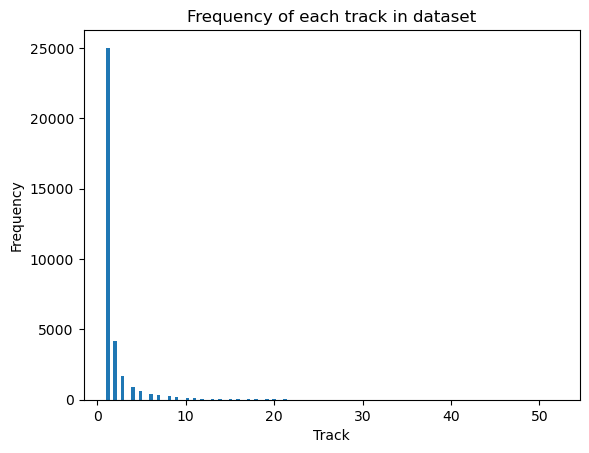

In [5]:
track_freq = user_item_matrix.sum(axis=1)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         }
plt.rcParams.update(params)
plt.style.use("default")
plt.hist(track_freq,bins=125,label="Unique tracks")
plt.gca().set(title = "Frequency of each track in dataset",
              ylabel = "Frequency",
              xlabel = "Track");

## Obtain Audio Features of Each Track

Use Spotify API to gather information on the following features of a track:
* danceability

* energy

* key

* loudness

* mode

* speechiness

* acousticness

* instrumentalness

* liveness

* valence

* tempo

In [ ]:
##################################################
##         WARNING: THIS TAKES FOREVER          ##
##    ONLY run if data doesn't already exist.   ##
##    Otherwise, run the next block instead.    ##           
##################################################

feature_stats = pd.DataFrame(data=None, columns=['danceability','energy','key','loudness','mode',
                                                 'speechiness','acousticness','instrumentalness',
                                                 'liveness','valence','tempo'])
for i in range(0,len(all_tracks)):    
    try:
        feats = audio_methods.getAudioFeatures(all_tracks[i])
        add_new = {
            'danceability':feats['danceability'],
            'energy':feats['energy'],
            'key':feats['key'],
            'loudness':feats['loudness'],
            'mode':feats['mode'],
            'speechiness':feats['speechiness'],
            'acousticness':feats['acousticness'],
            'instrumentalness':feats['instrumentalness'],
            'liveness':feats['liveness'],
            'valence':feats['valence'],
            'tempo':feats['tempo']
        }
        feature_stats = feature_stats.append(add_new,ignore_index=True)
    except:
        add_new = {
            'danceability':-199,
            'energy':-199,
            'key':-199,
            'loudness':-199,
            'mode':-199,
            'speechiness':-199,
            'acousticness':-199,
            'instrumentalness':-199,
            'liveness':-199,
            'valence':-199,
            'tempo':-199
        }
        feature_stats = feature_stats.append(add_new,ignore_index=True)

# Export data to csv, to save time next run.
feature_stats.to_csv("./data_frames/feature_stats.csv")

In [6]:
######################################
## Only run if data already exists  ##
######################################

feature_stats = pd.read_csv("./data_frames/feature_stats.csv",usecols = range(1,12))
feature_stats.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000
mean,0.578946,0.630797,5.207299,-7.613708,0.659408,0.085500,0.257960,0.071164,0.191722,0.480304,121.675926
std,1.087887,1.099056,3.748348,4.095125,1.174803,1.077521,1.114951,1.094688,1.086309,1.102140,29.356377
min,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000
25%,0.476000,0.490000,2.000000,-9.170000,0.000000,0.035100,0.020200,0.000000,0.095800,0.292000,98.555500
50%,0.592000,0.669000,5.000000,-6.698000,1.000000,0.048900,0.126000,0.000008,0.128000,0.477000,120.858000
75%,0.705000,0.818000,8.000000,-5.004000,1.000000,0.095950,0.445000,0.002680,0.252000,0.677000,140.030500
max,0.988000,1.000000,11.000000,2.766000,1.000000,0.962000,0.996000,0.995000,1.000000,0.998000,219.297000


## Data Cleaning

Clearly there is something wrong with one of the datapoints (note the mins of each column). That -199 means the try-catch caught something when calling Spotipy. We remove datapoint(s) with errors using the following code.

In [13]:
try:
    print("The following indices had issues:")
    null_indices = feature_stats.loc[feature_stats['energy'] == -199].index[0]
    del all_tracks[-null_indices]
    feature_stats = feature_stats.drop(axis=0,index=null_indices)
    print(null_indices)
    del null_indices
    feature_stats.describe()
except:
    print("No nulls found / nulls are cleaned up")

The following indices had issues:
No nulls found / nulls are cleaned up


Track 15933 was the culprit. Now the basic statistics looks managable.

# Data Preparation

K-Means clustering requires all datapoints to have equal variance. We address this by normalizing each column so they have mean of 0 and variance of 1.

"Key" and "Mode" are categorical variable that lose their meanings once normalized. An option is to hot encode them, however, we will be deleting them from our dataset instead. Normalization will still affect post-hot encoding variables.

In [22]:
normalized_feature_stats = feature_stats.drop(columns=['key','mode'])
print(normalized_feature_stats.mean().columns)
normalized_feature_stats.mean().to_csv("./data_frames/normalized_features_mean.csv")
normalized_feature_stats.std().to_csv("./data_frames/normalized_features_std.csv")
normalized_feature_stats = (normalized_feature_stats-normalized_feature_stats.mean())/normalized_feature_stats.std()
normalized_feature_stats.describe().apply(lambda s: s.apply('{0:.5f}'.format))

AttributeError: 'Series' object has no attribute 'columns'

In [9]:
normalized_feature_stats

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.943738,0.782658,0.126956,0.293665,-0.774129,-0.320391,-0.898376,1.329710,0.128840
1,1.152261,0.893574,0.932112,0.224497,-0.794760,-0.237836,0.265771,1.797710,0.728685
2,0.482550,0.538642,0.258667,1.173088,-0.869696,-0.352305,-0.822518,0.882237,-0.765246
3,1.864590,0.343429,0.391893,0.481407,-0.205457,-0.351233,-0.868511,1.362552,-0.706794
4,1.633235,-0.135729,0.760029,-0.197429,-0.690941,-0.352305,0.689857,0.689290,-0.918799
...,...,...,...,...,...,...,...,...,...
34438,0.512992,-1.812783,-1.138182,-0.220155,1.757777,-0.054687,-0.615851,-0.345234,-1.319230
34439,-0.558545,0.401106,0.650270,1.242256,-0.587123,-0.352305,-0.409184,-0.809129,-1.652440
34440,0.713905,-0.499534,-0.782662,-0.118379,0.227120,-0.099101,0.600262,-0.907655,0.627988
34441,-0.461133,-1.555457,-1.794974,0.313427,0.460046,-0.352252,-0.397237,-0.932286,-0.001782


# Data Modeling

K-Means Clustering is an unsupervised learning method, which makes it harder to cross validate. There isn't a "correct" label that any cluster or record belongs. We continue to train the model, then validate by observing cluster separation and cohesion.

Basic Framework:

1. Principal Component Analysis to reduce dimensionality

2. Repeat K-Means Clustering for multiple Ks

3. Compare Separation and Cohesion Metrics to find optimal K

## Principal Component Analysis

Text(0.5, 1.0, 'Variance explained by number of components')

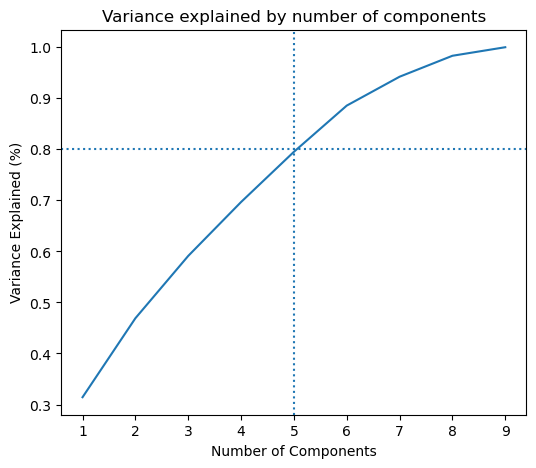

In [10]:
pca = PCA()
train_t = pca.fit(normalized_feature_stats)
plt.figure(figsize=(6,5))
plt.plot(range(1,10),train_t.explained_variance_ratio_.cumsum())
plt.axvline(x=5,linestyle='dotted')
plt.axhline(y=0.8,linestyle='dotted')

plt.xlabel("Number of Components")
plt.ylabel("Variance Explained (%)")
plt.title("Variance explained by number of components")

We typically aim for around 80-90% of variance explained. Therefore, 5 components are sufficient enough to describe the data's variance. The 5 components are as follows:

In [11]:
pca = PCA(n_components=5)
pca = pca.fit(normalized_feature_stats)
train_pca = pca.transform(normalized_feature_stats)

attributes = ['danceability','energy','loudness','speechness','acousticness',
               'instrumentalness','liveness','valence','tempo']
PC_cols = ['PC1','PC2','PC3','PC4','PC5']
temp = pd.DataFrame(pca.components_,columns=attributes)
temp = temp.rename(index={0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'})
temp

,danceability,energy,loudness,speechness,acousticness,instrumentalness,liveness,valence,tempo
PC1,-0.242478,-0.518602,-0.506015,-0.129862,0.468243,0.253460,-0.093979,-0.299849,-0.130793
PC2,0.638425,-0.236264,-0.162139,0.250138,0.186233,-0.195441,-0.235850,0.421365,-0.376405
PC3,-0.066638,-0.066236,-0.108782,0.667409,0.147361,-0.157772,0.691617,-0.079477,0.051434
PC4,-0.035981,0.100479,0.121475,-0.321223,-0.094297,-0.007587,0.400354,-0.128729,-0.827566
PC5,0.156113,0.164308,-0.144209,0.055038,-0.082278,0.870099,0.208826,0.341997,0.019855


PC1 correlates well with energy, loudness, and acousticness - so these variables are the source of most of the variance. The more acousticness of a track, the less energy and loudness the track has and vice versa.

PC2 has strong danceability and somewhat strong valence correlations, both with positive. These are the source of the second most varied variables.

PC3 corresponds with speechness and liveness (0.66 and 0.69, respectively).

PC4 negatively correlates with tempo,

PC5 positively correlates with instrumentalness.

We can fit our data using these principal components (also called eigenvectors). We can interpret the new matrix as "Track 0 can be described by 5 components (-1.75,1.75,-0.78,-0.63,0.48)".

In [12]:
train_pca = pd.DataFrame(train_pca,columns=PC_cols)
train_pca.to_csv("./data_frames/pca_item_matrix.csv")